In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from importlib import reload  # Python 3.4+

import torch

import lib.config as cfg
import lib.model as ts_model
import lib.ts_util as ts_util
import lib.plot_util as plot_util

In [2]:
df_train = pd.read_pickle('df_train_median.pkl') # this is much faster than read from csv
pid_list_train = np.unique(df_train['patientunitstayid'])
len(df_train)

843287

In [3]:
# def columns
col_all = df_train.columns
col_meta = ['patientunitstayid', 'tsid']
col_label = list(col_all[list(map(lambda x: 'label_' in x, col_all))])
col_label_used = col_label[1:] # remove gt_column
col_regres = list(col_all[list(map(lambda x: 'regres_' in x, col_all))])
col_to_drop = col_meta + col_label + col_regres

# def max time series length
max_ts_length = 128

# build model cfg
model_config = {
    'col_to_drop': col_to_drop,
    'col_label': col_label,
    'col_regres': col_regres,
    'max_ts_length': max_ts_length,
}

In [5]:
num_layers = 2
feature_size = df_train.shape[-1] - len(col_to_drop)
embedding_size = 256
hidden_size = 128
tagset_size = len(col_label_used) + len(col_regres)

model = ts_model.RNN_v4(num_layers, feature_size, embedding_size, hidden_size, tagset_size)
model.load_state_dict(torch.load('./gru_v4_ep100.pth'))
model.eval()
model.cuda()

RNN_v4(
  (fc1): Linear(in_features=476, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (rnn): GRU(256, 128, num_layers=2)
  (fc_out): Linear(in_features=128, out_features=8, bias=True)
)

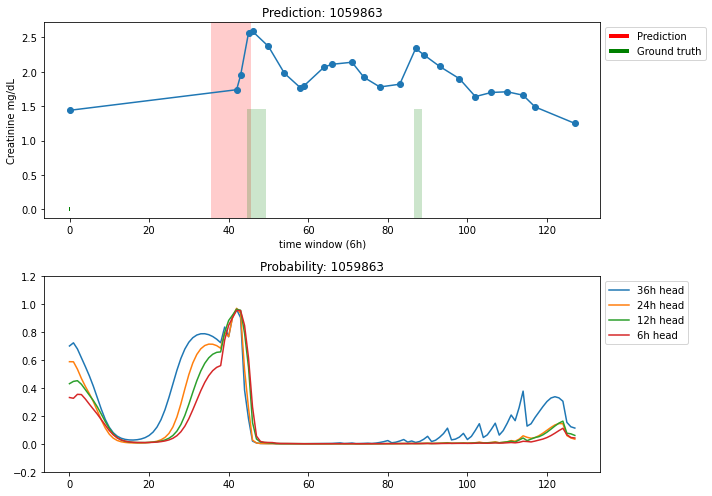

In [16]:
pid, model_out = plot_util.get_model_pred(model, model_config, df_train, df_train, pid=1059863)
df_dataset = df_train[df_train['patientunitstayid'] == pid]

ts_length = min(128, len(df_dataset['tsid']))

tsid = df_dataset['tsid'][:ts_length]
prob_aki = model_out[:len(tsid),3] 
label_pred = (prob_aki >= 0.5).astype(int)

label_gt = list(df_dataset['label_aki_gt'])
label_train_gt = list(df_dataset['label_aki_12h'])

arr_creat = df_dataset['creatinine_max'].copy()

arr_creat = arr_creat[:ts_length]
label_pred = label_pred[:ts_length]
label_gt = label_gt[:ts_length]
label_train_gt = label_train_gt[:ts_length]

#######

fig = plt.figure(figsize=(10,7))

pid_str = str(int(df_dataset.iloc[0]['patientunitstayid']))
ax_time = np.array(range(len(arr_creat)))
s1mask = np.isfinite(arr_creat)

ax = fig.add_subplot(211)
ax.plot(ax_time[s1mask], arr_creat[s1mask], linestyle='-', marker='o')
ax.set_title('Prediction: ' + pid_str)
ax.set_ylabel('Creatinine mg/dL')
ax.set_xlabel('time window (6h)')

plot_util.timelines(label_pred, 0, 'r', 'Prediction')
plot_util.timelines(label_gt, 0, 'g', 'Ground truth')
# timelines(label_train_gt, -0.1, 'g', 'AKI train label')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax = fig.add_subplot(212)
ax.plot(ax_time, model_out[:len(tsid),0] , linestyle='-', label='36h head')
ax.plot(ax_time, model_out[:len(tsid),1] , linestyle='-', label='24h head')
ax.plot(ax_time, model_out[:len(tsid),2] , linestyle='-', label='12h head')
ax.plot(ax_time, model_out[:len(tsid),3] , linestyle='-', label='6h head')
ax.set_ylim(top=1.2, bottom=-0.2)
ax.set_title('Probability: ' + pid_str)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()